## ODE Population Dynamics Model
$$
\begin{align}
    \frac{dC}{dt} &= -\iota C(V + D), \\
    \frac{dC_V}{dt} &= \iota CV - C_V(\iota D + \alpha_{L}), \\
    \frac{dC_D}{dt} &= \iota (CD - C_D V), \\
    \frac{dC_{DV}}{dt} &= \iota (C_D V + C_V D) - \alpha_{L} C_{DV}, \\
    \frac{dV}{dt} &= \alpha_L \eta \left(C_V+ \frac{C_{DV}}{\kappa} \right) - \iota V (C + C_D), \\
    \frac{dD}{dt} &= \alpha_{L} \beta_N \eta \left(C_V+ \frac{C_{DV}}{\kappa} \right) + \alpha_L \delta \eta \frac{C_{DV}}{\kappa} - \iota D (C + C_V).
\end{align}
$$
Adapted from Muñoz-Sánchez et al. 2025


In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

# Class for running the population dynamics model

class ViralDynamicsModel:
    def __init__(
        self,
        B=100,    # Burst size (total particles released after cell lysis)
        betaN=0.1, # Fraction of DVGs produced per Virus due to erroneous replication
        delta=2,  # Replication advantage of DVGs
        iota=1e-3, # Infection rate
        alpha=0.5, # Virus infection-induced cell death rate
        initial_conditions=None
    ):
        self.B = B
        self.betaN = betaN
        self.delta = delta
        self.iota = iota
        self.alpha = alpha
        
        self.eta = B / (1 + betaN)
        self.kappa = 1 + delta / (1 + betaN)
        
        if initial_conditions is None:
            self.initial_conditions = (1000, 0, 0, 0, 100, 10)
        else:
            self.initial_conditions = initial_conditions

    def system(self, t, y):
        C, CV, CD, CDV, V, D = y
        
        dC_dt = -self.iota * C * (V + D)
        
        dCV_dt = self.iota * C * V - CV * (self.iota * D + self.alpha)
        
        dCD_dt = self.iota * C * D - self.iota * CD * V
        
        dCDV_dt = self.iota * (CD * V + CV * D) - self.alpha * CDV
        
        dV_dt = self.alpha * self.eta * (CV + CDV / self.kappa) - self.iota * V * (C + CD)
        
        dD_dt = (self.alpha * self.betaN * self.eta * (CV + CDV / self.kappa) + 
                self.alpha * self.delta * self.eta * CDV / self.kappa) - self.iota * D * (C + CV)
        
        return [dC_dt, dCV_dt, dCD_dt, dCDV_dt, dV_dt, dD_dt]

    def solve(self, t_span, t_eval=None):
        sol = solve_ivp(
            self.system,
            t_span,
            self.initial_conditions,
            method='LSODA',
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-9
        )
        return sol

    def plot_results(self, sol, fig_size=(12, 10)):
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        
        t = sol.t
        C, CV, CD, CDV, V, D = sol.y
        
        axes[0].plot(t, C, label='Uninfected cells (C)', linewidth=2)
        axes[0].plot(t, CV, label='Virus-infected cells (CV)', linewidth=2)
        axes[0].plot(t, CD, label='DVG-infected cells (CD)', linewidth=2)
        axes[0].plot(t, CDV, label='Co-infected cells (CDV)', linewidth=2)
        axes[0].set_ylabel('Cell count')
        axes[0].set_title('Cell Dynamics')
        axes[0].legend(loc='upper right')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(t, V, label='Virus (V)', linewidth=2)
        axes[1].plot(t, D, label='Defective Viral Genomes (D)', linewidth=2)
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Virus count')
        axes[1].set_title('Viral Dynamics')
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)
        
        if np.max(V) / np.min(V[V>0]) > 1000 or np.max(D) / np.min(D[D>0]) > 1000:
            axes[1].set_yscale('log')
        
        plt.tight_layout()
        return fig, axes

    def simulate_parameter_variations(self, parameter_name, parameter_values, t_span, t_eval=None):
        original_value = getattr(self, parameter_name)
        solutions = []
        
        for value in parameter_values:
            setattr(self, parameter_name, value)
            
            if parameter_name in ['B', 'betaN', 'delta']:
                self.eta = self.B / (1 + self.betaN)
                self.kappa = 1 + self.delta / (1 + self.betaN)
            
            sol = self.solve(t_span, t_eval)
            solutions.append((value, sol))
        
        setattr(self, parameter_name, original_value)
        if parameter_name in ['B', 'betaN', 'delta']:
            self.eta = self.B / (1 + self.betaN)
            self.kappa = 1 + self.delta / (1 + self.betaN)
        
        return solutions

    def plot_parameter_variations(self, solutions, parameter_name, fig_size=(10, 10)):
        sns.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(solutions)))
        
        for i, (value, sol) in enumerate(solutions):
            t = sol.t
            _, _, _, _, V, D = sol.y
            
            axes[0].plot(t, V, color=colors[i], 
                        label=f'{parameter_name}={value}', linewidth=2)
            axes[1].plot(t, D, color=colors[i], 
                        label=f'{parameter_name}={value}', linewidth=2)
        
        axes[0].set_ylabel('Virus (V)')
        axes[0].set_title(f'Virus Dynamics for Different {parameter_name} Values')
        axes[0].legend(loc='upper right')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Defective Viral Genomes (D)')
        axes[1].set_title(f'DVG Dynamics for Different {parameter_name} Values')
        axes[1].legend(loc='upper right')
        axes[1].grid(True, alpha=0.3)
        
        for ax in axes:
            ylim = ax.get_ylim()
            if ylim[1] / ylim[0] > 1000:
                ax.set_yscale('log')
        
        plt.tight_layout()
        return fig, axes

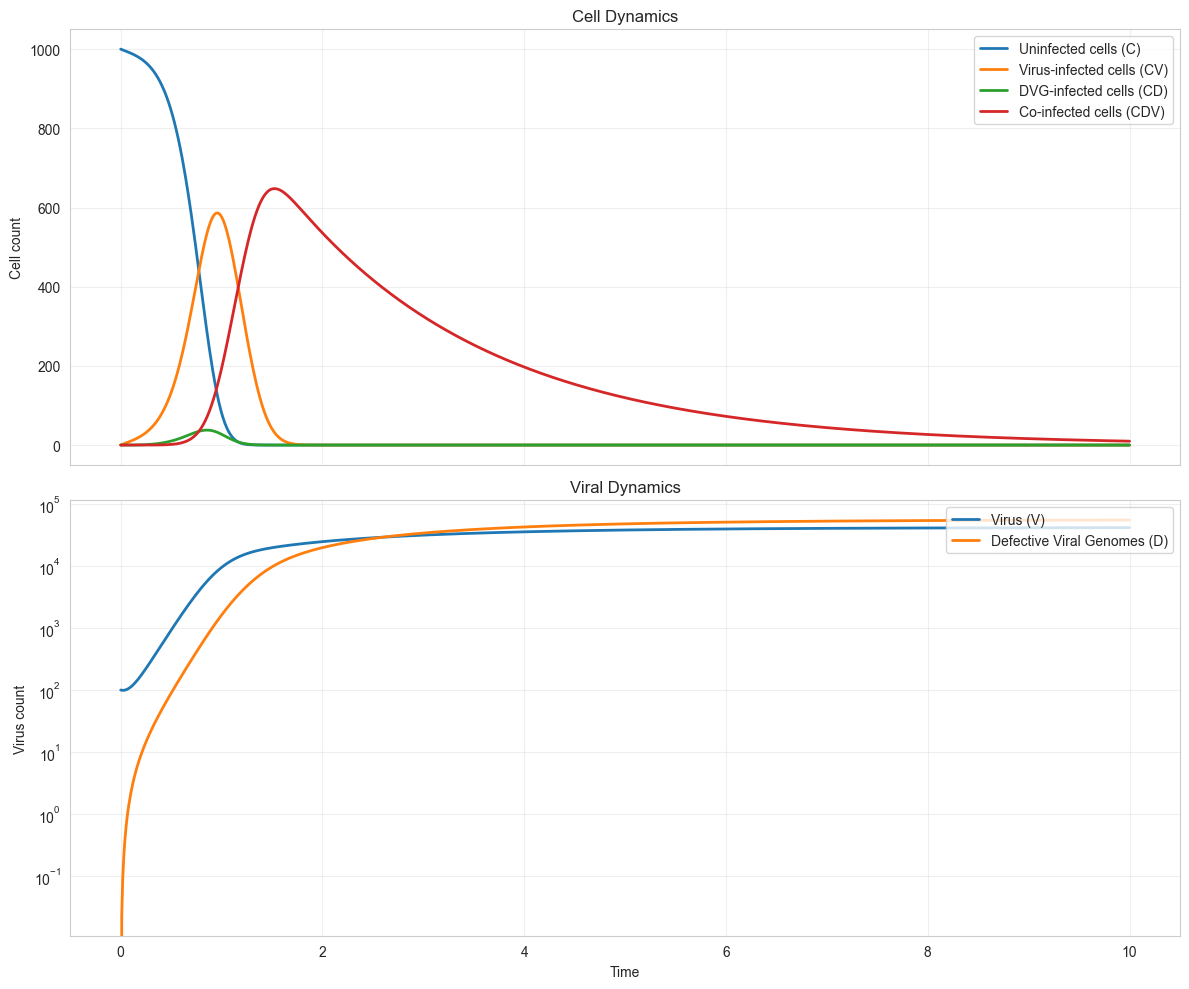

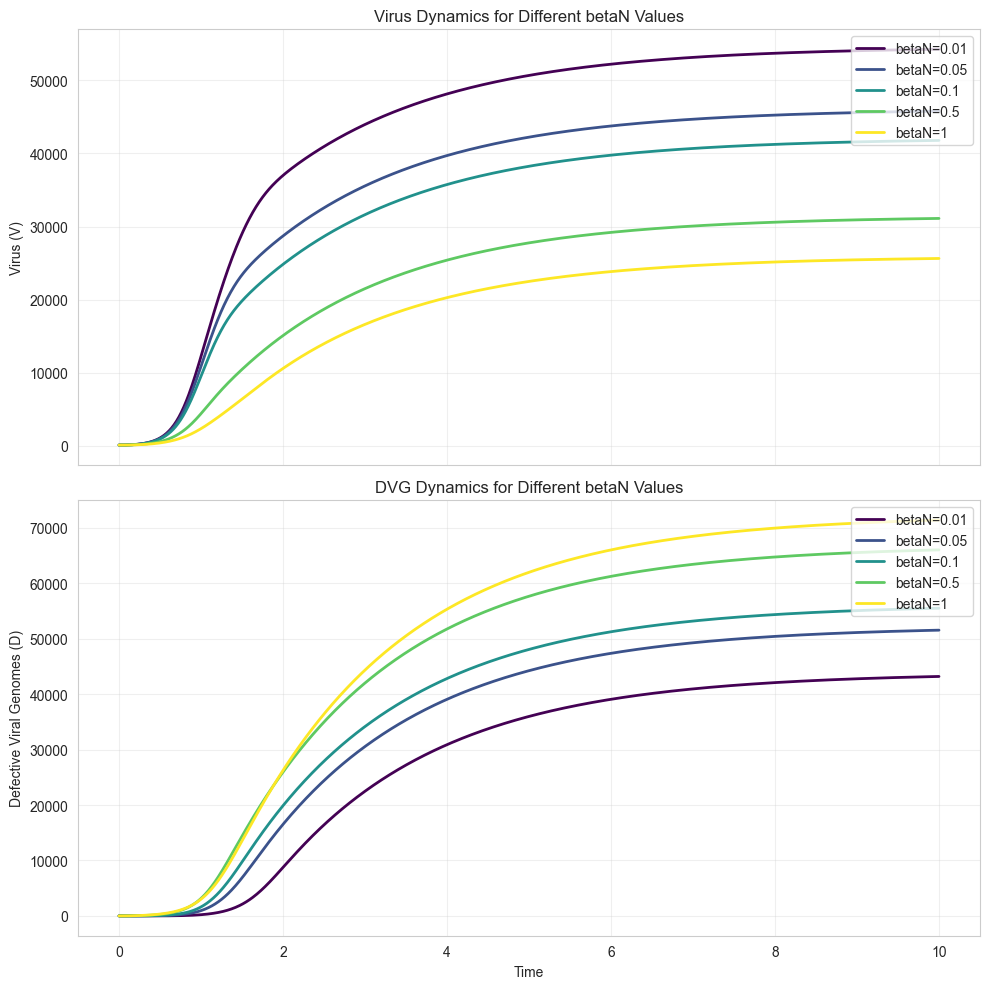

In [ ]:
# Initialize the model
model = ViralDynamicsModel(
    B=100,       # Burst size
    betaN=0.1,    # Fraction of DVGs produced per virus
    delta=2.0,   # Replication advantage of DVGs
    iota=1e-3,   # Infection rate
    alpha=0.5,   # Cell death rate
    # Initial conditions: (C, CV, CD, CDV, V, D)
    initial_conditions=(1000, 0, 0, 0, 100, 0)
)

# Solve the system
T = 10 # Time span to run the model
t_span = (0, T)
t_eval = np.linspace(0, T, 1000)  # Evaluate at 1000 points
sol = model.solve(t_span, t_eval)

fig, axes = model.plot_results(sol)

# Example Parameter Analysis
betaN_values = [0.01, 0.05, 0.1, 0.5, 1]
solutions = model.simulate_parameter_variations('betaN', betaN_values, t_span, t_eval)
fig, axes = model.plot_parameter_variations(solutions, 'betaN')

plt.show()